<a href="https://colab.research.google.com/github/ck1972/Hands-On-GeoAI1/blob/main/GeoAI_Lab_4b_Random_Forest_Regression_for_Aboveground_Biomass_Density_(AGBD)_Estimation_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest Regression for Aboveground Biomass Density (AGBD) Estimation**

## Introduction
The aim of the script is to model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A), Sentinel-2 (S2), Normalized Difference Vegetation Index (NDVI), Canopy Chlorophyll Content Index (CCCI), Specific Leaf Area Vegetation Index (SLAVI), and a random forest model.

## Install Libraries

Install the necessary libraries.

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

Next, import the following libraries.

In [ ]:
# Import the libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.features import rasterize
import earthpy.plot as ep
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Setting-up Colab
## Mount your Google Drive
First, make sure that your data is loaded in Google Drive. After that mount your Google Drive using the code below.

In [ ]:
# Import the neccessary library
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access the raster and vector datasets
Import the raster  and vector datasets. Prepare the features and labels.

In [ ]:
# Define predictor and target variables, and the path that contains the datasets
Predictors = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI','CCCI','SLAVI']
Target = ['agbd']
SAMPLE_PATH = '/content/drive/My Drive/Maf_Datasets/Cleaned_GEDI_L4A_2022_Dataset1.csv'
IMAGE_PATH = '/content/drive/My Drive/Maf_Datasets/S2_predictors_2022.tif'

## Create image composites
Load and display the imagery.

/usr/local/lib/python3.11/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


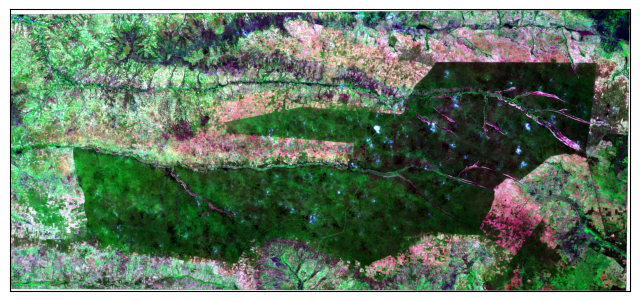

<Axes: >

In [ ]:
# Load the image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [9, 7, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Prepare datasets for modeling
## Import the sample data

Next, we are going to load the sample data with the aboveground biomass density (AGBD) and raster variables.

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)[Predictors + Target]
samples

## Split training data
First, let's split the training points into training and test datasets.

In [ ]:
# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)

# Get variables input and output
X_train = train[Predictors]
X_test = test[Predictors]
y_train = train[Target].astype(float)
y_test = test[Target].astype(float)

# Show the data shape
print(f'Train predictors: {X_train.shape}\nTest predictors: {X_test.shape}\nTrain target: {y_train.shape}\nTest target: {y_test.shape}')

Train predictors: (41800, 12)
Test predictors: (10451, 12)
Train target: (41800, 1)
Test target: (10451, 1)


## Perform exploratory data analysis (EDA)
Exploratory data analysis (EDA) is an important step in understanding your data before building a machine learning model. To perform EDA on your training dataset, we will use libraries such as pandas for data manipulation and matplotlib or seaborn for data visualization. First, we will start by creating a DataFrame for the training dataset.

In [ ]:
# Create a DataFrame from X_train and y_train
train_df = pd.DataFrame(data=np.c_[X_train, y_train], columns=[f'Band_{i}' for i in range(X_train.shape[1])] + ['agbd'])

# Rename columns in the DataFrame train_df
train_df.columns = Predictors + ['agbd']

We will take a quick look at the top five rows using the DataFrame's head() method.

In [ ]:
# Check the first five rows
train_df.head()

Let's use the info() method to get a quick description of the data.

In [ ]:
# Use the info()to check the data
train_df.info()

Next, we will use the describe() method to get summary statistics of the training dataset. This will provide statistics such as mean, standard deviation, minimum, maximum, and quartiles for each feature and the target variable.

In [ ]:
# Print summary statistics
summary_stats = train_df.describe()
print(summary_stats)

We will visualize the distribution and potential outliers of each feature using boxplots. This code will generate a boxplot for each feature, showing the median, quartiles, and any potential outliers.

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create boxplots for each feature
sns.boxplot(data=train_df.drop(columns=['agbd']), orient='v')
plt.title('Boxplots of Features')
plt.xlabel('Features')
plt.ylabel('Spectral reflectance')
plt.show()

# Select and Train a Model Training
## Training a random forest regression model
We will start with a random forest regression model. Note that 'y_train' is now a column-vector.

In [ ]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train.values.ravel())

Let's create a scatter plot for the RF model.


In [ ]:
# Predict test data
rf_prediction = rf_model.predict(X_test).flatten()
label = y_test.values.flatten()

# Calculate MBE
mbe = np.mean(rf_prediction - label)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(label, rf_prediction))

# Calculate R2
r2 = r2_score(label, rf_prediction)

print(f'Mean Bias Error (MBE): {mbe}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Calculate the absolute difference between predicted and actual values
absolute_diff = np.abs(rf_prediction - label)

# Plot the scatter plot with colors based on the absolute difference
plt.scatter(label, rf_prediction, c=absolute_diff, cmap='viridis')
m, b = np.polyfit(label, rf_prediction, 1)
plt.plot(label, m * label + b)
plt.title('Reference vs Estimated Mean AGBD (RF Model 1)')
plt.xlabel('GEDI reference Mean AGBD (Mg/ha)')
plt.ylabel('Estimated Mean AGBD (Mg/ha)')
plt.colorbar(label='Absolute Difference')  # Adding a colorbar for reference
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m, b)])

plt.show()

## Save the best RF model
Let's save the best RF model parameters, feature names, or other metadata together.

In [ ]:
# joblib library or module.
import joblib

# Save the model
MODEL_PATH = '/content/drive/MyDrive/Maf_Datasets/rf_model1.pkl'

model_package = {
    "model": rf_model,
    "features": Predictors,
    "label": Target
}
joblib.dump(model_package, MODEL_PATH)

# Load with:
package = joblib.load(MODEL_PATH)
loaded_model = package["model"]

## Predict and display agbd map
Next, we will predict and display agbd map. Note that the final agbd image map will be exported as a GeoTIFF file, which can be visualized in any GIS software.

In [ ]:
# Read all 12 bands from the image (assuming 12-band image)
image_input = []
for x in range(12):
    image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(12, -1).T  # shape: (pixels, features)

# Predict using the trained Random Forest model
rf_prediction = rf_model.predict(image_input)

# Reshape prediction to 2D image
rf_prediction = rf_prediction.reshape(shape[0], shape[1])

# Visualize the predicted raster
ep.plot_bands(rf_prediction, cmap='YlGn', figsize=plot_size)

## Export to Drive
Save the predicted AGBD map from the RF model as geotiff.

In [ ]:
# Save file to drive
save_location = '/content/drive/My Drive/Maf_Datasets/'
name = 'RF_AGBD_2022a.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = rf_prediction.shape[0], width = rf_prediction.shape[1],
      count=1, dtype=str(rf_prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(rf_prediction, 1);
new_dataset.close()